In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from lightgbm import LGBMRegressor

In [3]:
pip install lightgbm

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/d9/28/3be76b591a2e14a031b681b8283acf1dec2ad521f6f1701b7957df68c466/lightgbm-4.5.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------- ----------------------- 0.6/1.4 MB 12.6 MB/s eta 0:00:01
   ------------------------------------- -- 1.4/1.4 MB 17.2 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 13.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
df=pd.read_csv('IMDb Movies India.csv', encoding='latin1')
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


In [7]:
df.isnull().sum()

Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

In [8]:
df.dropna(inplace=True)

In [9]:
df.shape

(5659, 10)

In [10]:
df.describe()

,Rating
count,5659.000000
mean,5.898533
std,1.381165
min,1.100000
25%,5.000000
50%,6.100000
75%,6.900000
max,10.000000


In [11]:
df.isna().sum()

Name        0
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64

In [63]:
genre_counts = df['Genre'].value_counts().reset_index()
genre_counts.columns = ['Genre', 'Count']
top_n_genres = genre_counts.head(5)
top_n_genres

,Genre,Count
0,229,804
1,28,329
2,284,323
3,38,206
4,151,204


In [12]:
df['Year']=df['Year'].str.extract(r'([0-9].{0,3})',expand=False)

In [13]:
df['Duration']=df['Duration'].str.extract(r'([0-9]+)',expand=False)

In [14]:
def get_mode_with_default(x):
    mode_result = x.mode()
    if not mode_result.empty:
        return mode_result[0]
    else:
        return 'unknown'  

df['Actor 1']=df['Actor 1'].fillna(df.groupby('Year')['Actor 1'].transform(get_mode_with_default))
df['Actor 2']=df['Actor 2'].fillna(df.groupby('Year')['Actor 2'].transform(get_mode_with_default))
df['Actor 3']=df['Actor 3'].fillna(df.groupby('Year')['Actor 3'].transform(get_mode_with_default))


In [15]:
df['Director']=df.groupby(['Year','Actor 1','Actor 2','Actor 3'])['Director'].transform(get_mode_with_default)

In [16]:
df['Duration']=pd.to_numeric(df['Duration'])

In [17]:
def get_mean_with_default(x):
    mean_result = x.mean()
    if not math.isnan(mean_result):        
            return round(mean_result)
    else:
        return 0
df['Duration']=df.groupby(['Year','Director','Actor 1','Actor 2','Actor 3'])['Duration'].transform(get_mean_with_default)

In [18]:
df['Rating']=df.groupby(['Director','Actor 1'])['Rating'].transform(lambda x:x.mean())
df['Rating']=df.groupby(['Director','Actor 2'])['Rating'].transform(lambda x:x.mean())
df['Rating']=df.groupby(['Director','Actor 3'])['Rating'].transform(lambda x:x.mean())
df['Rating']=df.groupby(['Year','Director'])['Rating'].transform(lambda x:x.mean())
df['Rating']=df.groupby('Year')['Rating'].transform(lambda x:x.mean())
df['Year']=pd.to_numeric(df['Year'])

In [19]:
df['Votes']=df['Votes'].str.extract(r'([0-9]+)',expand=False)
df['Votes']=pd.to_numeric(df['Votes'])

In [20]:
df['Votes']=df.groupby(['Year','Rating'])['Votes'].transform(lambda x:x.mean())

In [21]:
df['Votes']=df.groupby('Year')['Votes'].transform(lambda x:x.mean())

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5659 entries, 1 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      5659 non-null   object 
 1   Year      5659 non-null   int64  
 2   Duration  5659 non-null   int64  
 3   Genre     5659 non-null   object 
 4   Rating    5659 non-null   float64
 5   Votes     5659 non-null   float64
 6   Director  5659 non-null   object 
 7   Actor 1   5659 non-null   object 
 8   Actor 2   5659 non-null   object 
 9   Actor 3   5659 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 486.3+ KB


C:\Users\swara\AppData\Local\Temp\ipykernel_10336\3816769597.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


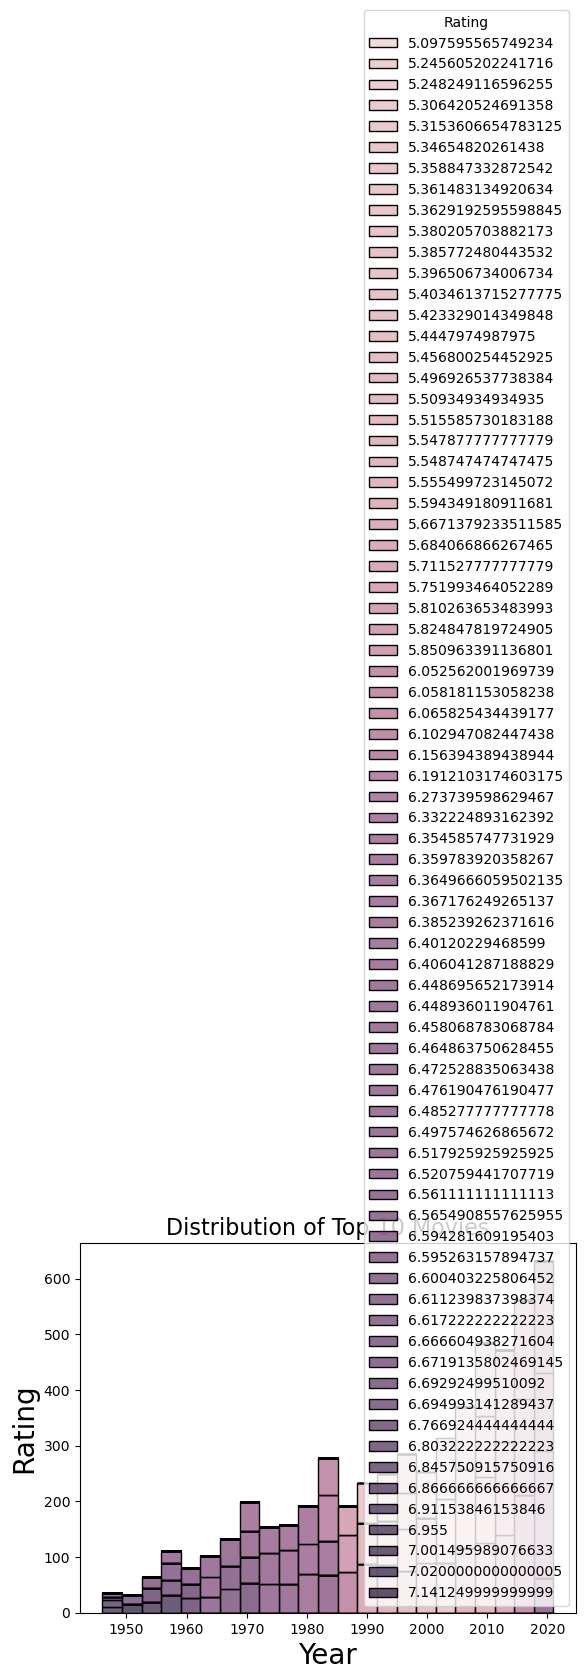

In [60]:
sns.histplot(data=df, x="Year",hue="Rating", multiple="stack")
plt.title('Distribution of Top 10 Movies', fontsize=16)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Rating', fontsize=20)
plt.tight_layout()
plt.show()

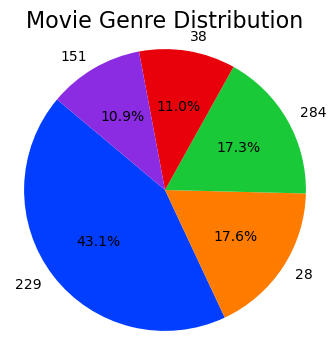

In [64]:
plt.figure(figsize=(4, 4))
plt.pie(top_n_genres['Count'], labels=top_n_genres['Genre'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('bright'))
plt.title('Movie Genre Distribution', fontsize=16)
plt.axis('equal')
plt.show()

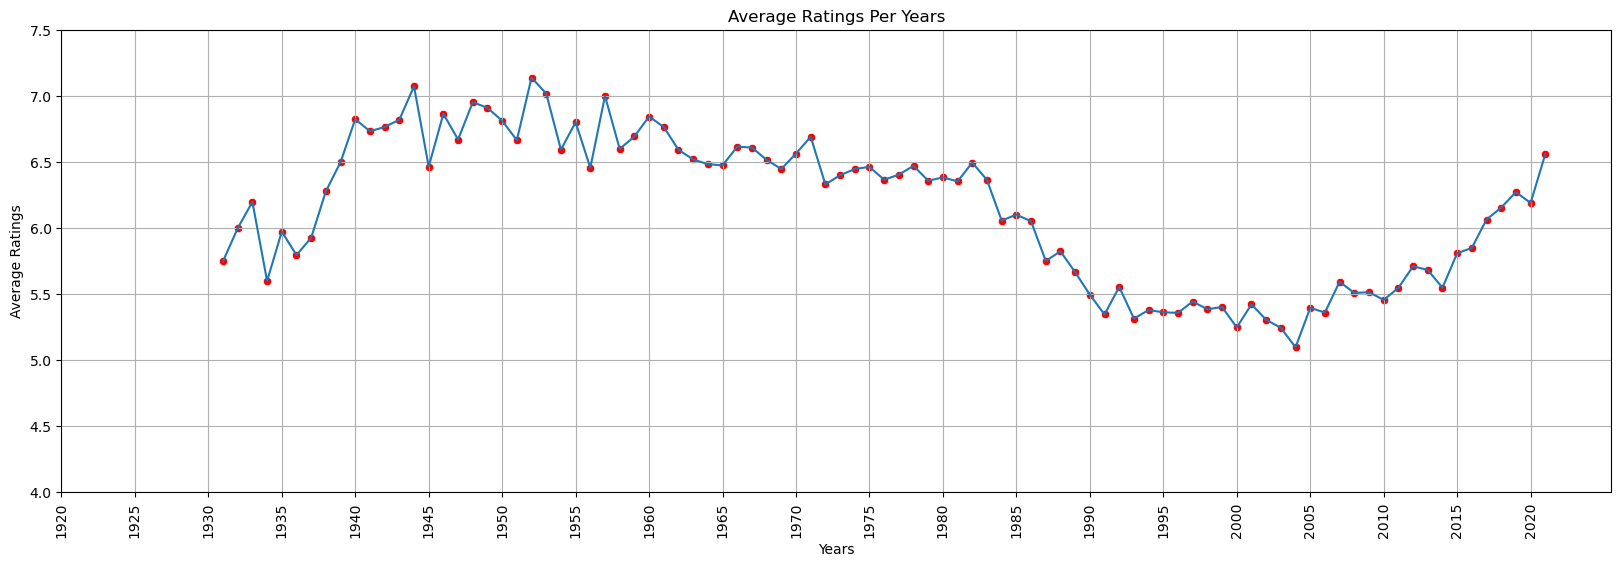

In [24]:
rating_avg=df.groupby('Year')['Rating'].mean().reset_index()

plt.figure(figsize=(20,6))
sns.lineplot(x='Year',y='Rating',data=rating_avg)
sns.scatterplot(x='Year',y='Rating',data=rating_avg,color='r')
plt.yticks(np.arange(4,8,0.5))
plt.xticks(np.arange(1920,2025,5))
plt.ylabel('Average Ratings')
plt.xlabel('Years')
plt.title('Average Ratings Per Years')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


In [79]:
df['Genre'] = df['Genre'].apply(str).str.replace(',', '')
genre_df = df.explode('Genre')

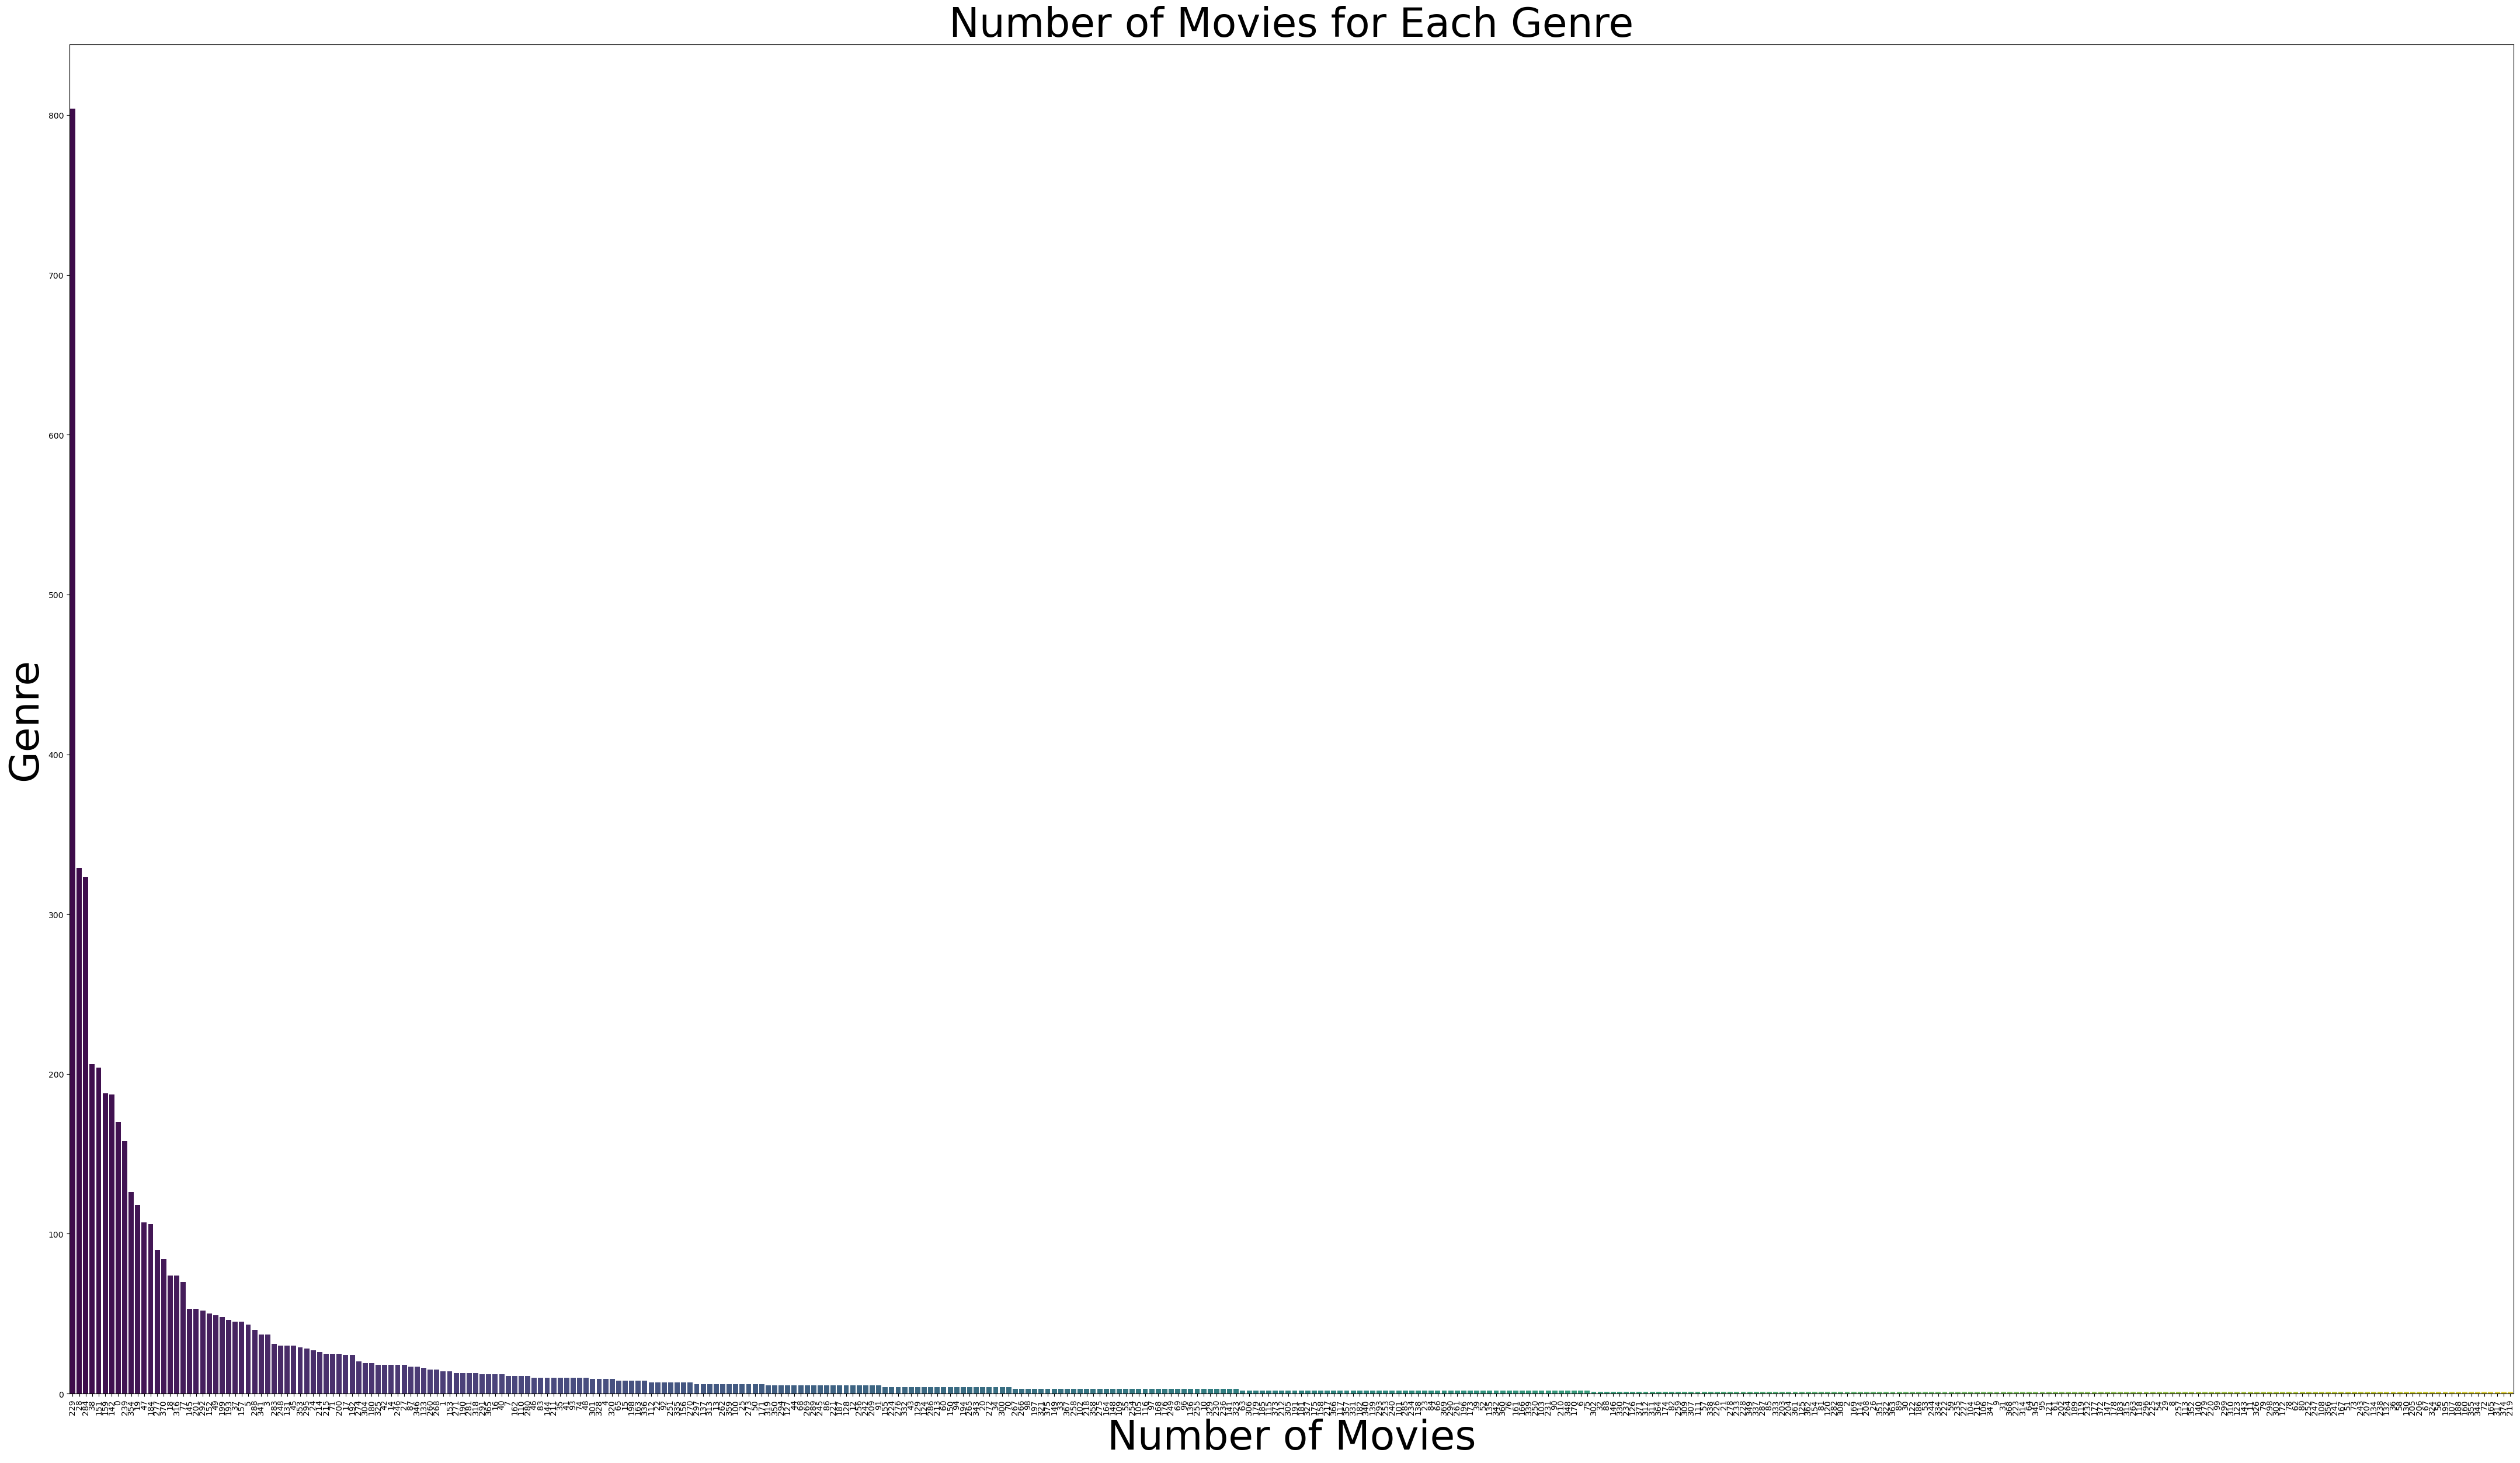

In [100]:
plt.figure(figsize=(54,30))
sns.countplot(data=genre_df, x='Genre', order=genre_df['Genre'].value_counts().index, palette='viridis')
plt.title('Number of Movies for Each Genre', fontsize=50)
plt.xlabel('Number of Movies', fontsize=50)
plt.ylabel('Genre', fontsize=50)
plt.xticks(rotation=90)
plt.show()

In [81]:
average_rating_by_genre = genre_df.groupby('Genre')['Rating'].mean().reset_index()
average_rating_by_genre = average_rating_by_genre.sort_values(by='Rating', ascending=False)

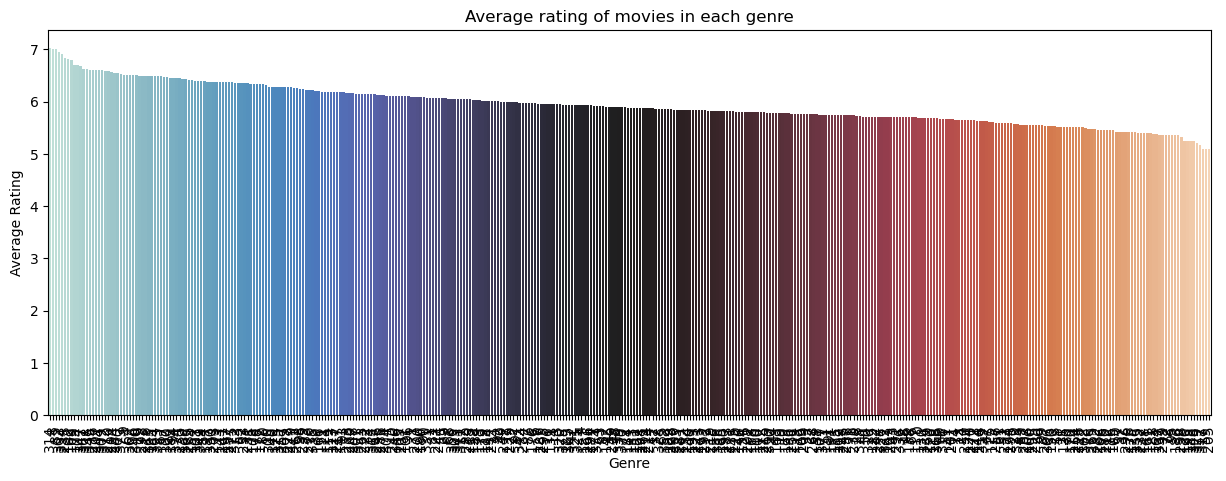

In [101]:
plt.figure(figsize=(15,5))
sns.barplot(data=average_rating_by_genre,y="Rating",x='Genre',palette='icefire')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.title('Average rating of movies in each genre')
plt.xticks(rotation=90)

plt.show()

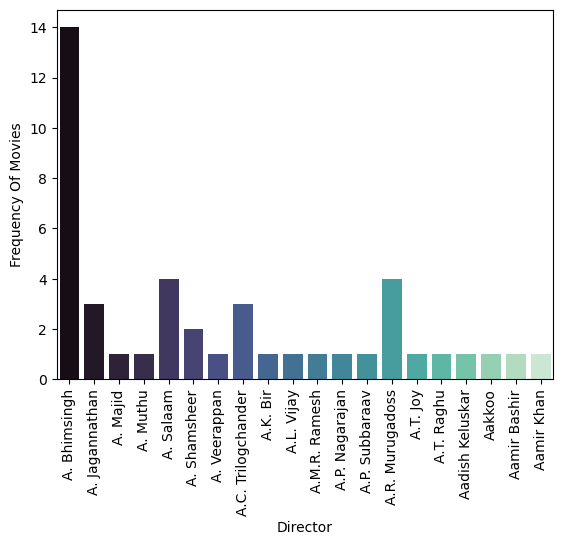

In [25]:
top_20=df.groupby('Director')['Name'].count()[0:20]
sns.barplot(x=top_20.index,y=top_20.values,data=df,palette='mako')
plt.xticks(rotation=90)
plt.ylabel('Frequency Of Movies')
plt.xlabel('Director')
plt.show()

Correlation Of Duration And Rating is -0.0006389520329854975


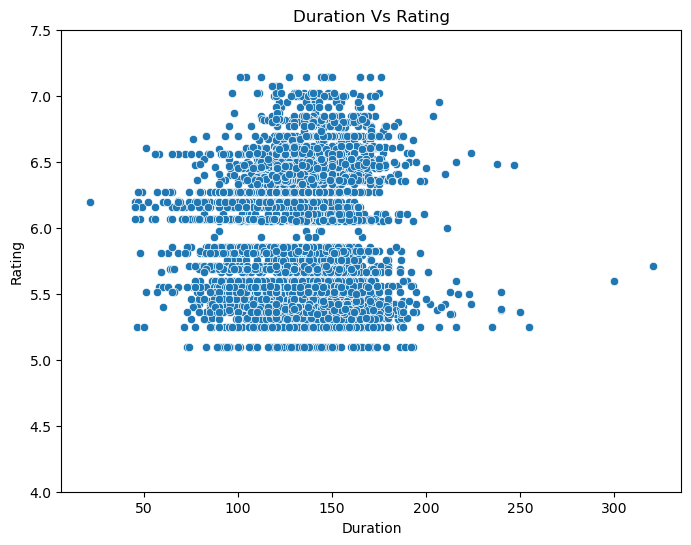

In [26]:
corr_leng_rat=df['Duration'].corr(df['Rating'])
print(f"Correlation Of Duration And Rating is {corr_leng_rat}")
plt.figure(figsize=(8,6))
sns.scatterplot(x="Duration",y='Rating',data=df)
plt.xlabel('Duration')
plt.ylabel('Rating')
plt.title('Duration Vs Rating')
plt.yticks(np.arange(4,8,0.5))
plt.show()

In [27]:
overall=df.nlargest(10,'Rating')
overall=overall=overall.reset_index(drop=True)
print("Top 10 Movies Overall:")
overall

Top 10 Movies Overall:


,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,Aandhiyan,1952,136,Drama,7.14125,94.0625,Chetan Anand,Dev Anand,Nimmi,Kalpana Kartik
1,Aladdin and the Wonderful Lamp,1952,144,"Adventure, Fantasy",7.14125,94.0625,Homi Wadia,Mahipal,Meena Kumari,S.N. Tripathi
2,Amber,1952,148,"Action, Adventure, Drama",7.14125,94.0625,Jayant Desai,Nargis,Raj Kapoor,Agha
3,Anand Math,1952,176,"Biography, Drama, History",7.14125,94.0625,Hemen Gupta,Prithviraj Kapoor,Geeta Bali,Ranjana
4,Anhonee,1952,148,"Drama, Romance, Thriller",7.14125,94.0625,Jayant Desai,Nargis,Raj Kapoor,Agha
5,Ashiana,1952,104,"Drama, Romance",7.14125,94.0625,B. Trilochan,Nargis,Raj Kapoor,Shivraj
6,Baiju Bawra,1952,165,"Drama, Musical, Romance",7.14125,94.0625,Vijay Bhatt,Meena Kumari,Bharat Bhushan,Surendra
7,Bewafa,1952,112,"Drama, Romance",7.14125,94.0625,M.L. Anand,Nargis,Ashok Kumar,Raj Kapoor
8,Chhatrapati Shivaji,1952,170,"Drama, History",7.14125,94.0625,Bhalji Pendharkar,Parshwanath Yeshwant Altekar,Chandrakant,Gajanan Jagirdar
9,Daag,1952,149,"Drama, Romance",7.14125,94.0625,Amiya Chakrabarty,Dilip Kumar,Nimmi,Usha Kiran


In [65]:
director_avg_rating = df.groupby('Director')['Rating'].mean().reset_index()

director_avg_rating = director_avg_rating.sort_values(by='Rating', ascending=False)

top_directors = director_avg_rating.head(10)
top_directors

,Director,Rating
1631,1631,7.141250
808,808,7.141250
343,343,7.141250
1062,1062,7.141250
446,446,7.020000
381,381,7.003958
310,310,7.001496
1067,1067,7.001496
1674,1674,7.001496
915,915,6.965769


Text(0, 0.5, 'Director')

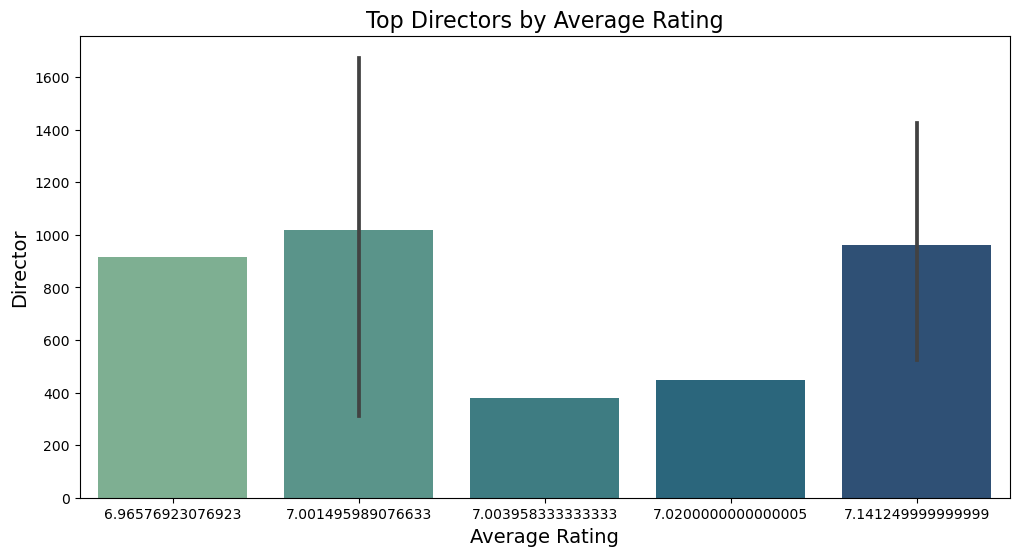

In [67]:
plt.figure(figsize=(12, 6))
sns.barplot(data=top_directors, x='Rating', y='Director', palette='crest')
plt.title('Top Directors by Average Rating', fontsize=16)
plt.xlabel('Average Rating', fontsize=14)
plt.ylabel('Director', fontsize=14)

In [68]:
actor_counts = df['Actor 1'].value_counts().reset_index()
actor_counts.columns = ['Actor', 'MovieCount']

top_n_actors = actor_counts.head(10)
top_n_actors

,Actor,MovieCount
0,155,104
1,956,93
2,462,90
3,675,89
4,283,84
5,111,82
6,1557,81
7,1271,74
8,86,70
9,1467,61


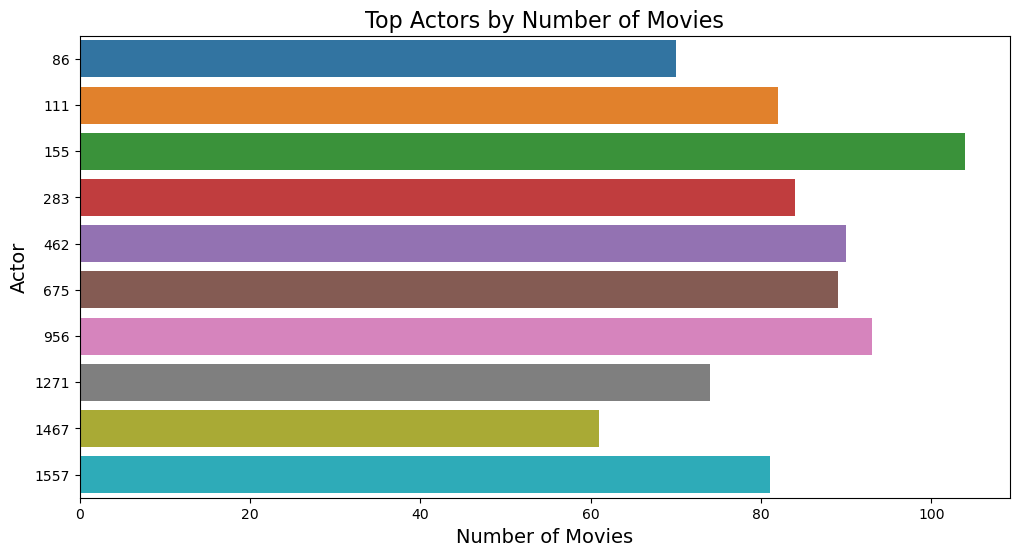

In [69]:
plt.figure(figsize=(12, 6))
sns.barplot(data=top_n_actors, x='MovieCount', y='Actor', orient='h')
plt.title('Top Actors by Number of Movies', fontsize=16)
plt.xlabel('Number of Movies', fontsize=14)
plt.ylabel('Actor', fontsize=14)
plt.show()

In [28]:
top_10_per_year=pd.DataFrame()
for year in df['Year'].unique():
    year_df=df[df['Year'] == year]
    top_10_year = year_df.nlargest(10, 'Rating').sort_values(by='Rating', ascending=False)
    top_10_year = top_10_per_year.append(top_10_year)
top_10_year  = top_10_year.reset_index(drop=True)
print("\nTop 10 Movies Per Year:")
top_10_per_year 


Top 10 Movies Per Year:


C:\Users\swara\AppData\Local\Temp\ipykernel_10336\284941015.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10_year = top_10_per_year.append(top_10_year)
C:\Users\swara\AppData\Local\Temp\ipykernel_10336\284941015.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10_year = top_10_per_year.append(top_10_year)
C:\Users\swara\AppData\Local\Temp\ipykernel_10336\284941015.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10_year = top_10_per_year.append(top_10_year)
C:\Users\swara\AppData\Local\Temp\ipykernel_10336\284941015.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10_year = top_10_per_year.append(top_10_ye

""


In [29]:
rat_bool=df['Rating']>=6
vot_bool=df['Votes']>110
pop_df=df[vot_bool & rat_bool]
pop_df

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,#Gadhvi (He thought he was Gandhi),2019,109,Drama,6.273740,127.665198,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,#Yaaram,2019,110,"Comedy, Romance",6.273740,127.665198,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
15,102 Not Out,2018,102,"Comedy, Drama",6.156394,119.470297,Umesh Shukla,Amitabh Bachchan,Rishi Kapoor,Vijay Raaz
22,12 O'Clock,2021,105,"Horror, Thriller",6.561111,132.666667,Ram Gopal Varma,Mithun Chakraborty,Makrand Deshpande,Dalip Tahil
41,1921,2018,144,"Horror, Mystery, Romance",6.156394,119.470297,Vikram Bhatt,Zareen Khan,Karan Kundra,Vikram Bhatt
...,...,...,...,...,...,...,...,...,...,...
15453,Zinda Laash,1986,112,Drama,6.052562,136.904110,Manmohan Sabir,Aakash,Akashdeep,Birbal
15454,Zindagani,1986,131,Drama,6.052562,136.904110,Prabhat Roy,Rakhee Gulzar,Mithun Chakraborty,Rati Agnihotri
15458,Zindagi,1976,139,"Drama, Romance",6.367176,121.666667,Ravi Tandon,Mala Sinha,Sanjeev Kumar,Vinod Mehra
15479,Zindagi Tumse,2019,120,Family,6.273740,127.665198,Tariq Bhat,Sadhana Singh,Guddi Maruti,Rajesh Puri


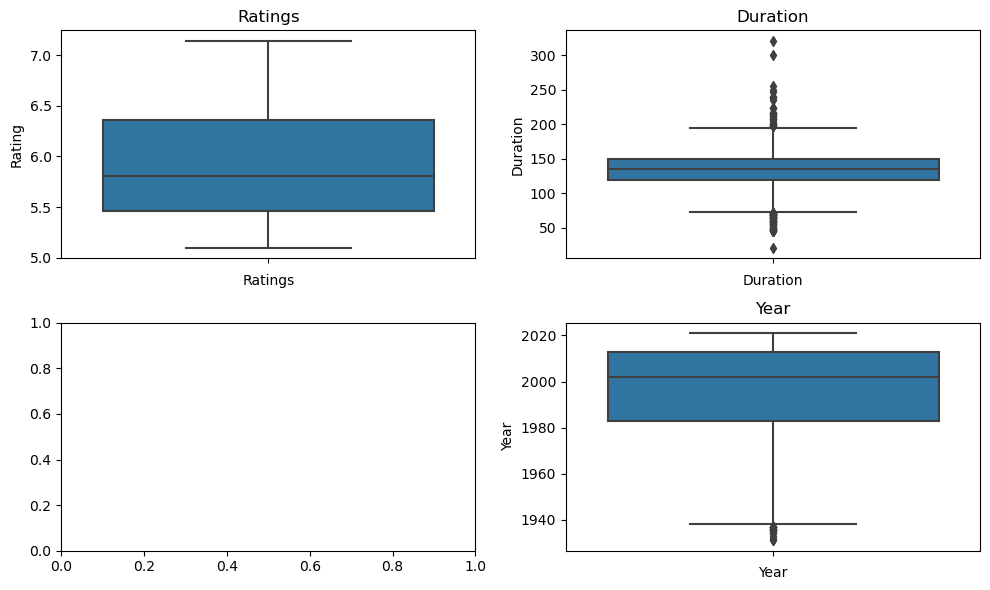

In [30]:
fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(10,6))
sns.boxplot(data=df,y='Rating',ax=ax[0][0])
ax[0][0].set_title('Ratings')
ax[0][0].set_xlabel('Ratings')
sns.boxplot(data=df,y='Duration',ax=ax[0][1])
ax[0][1].set_title('Duration')
ax[0][1].set_xlabel('Duration')
sns.boxplot(data=df,y='Year',ax=ax[1][1])
ax[1][1].set_title('Year')
ax[1][1].set_xlabel('Year')
plt.tight_layout()
plt.show()

In [31]:
def out(df,col,dis):
    q1=df[col].quantile(0.25)
    q3=df[col].quantile(0.75)
    iqr=q3-q1
    lower=q1-(iqr*dis)
    upper=q3+(iqr*dis)
    return lower,upper

In [32]:
votes_low,votes_up=out(df,'Votes',1.5)

In [33]:
vote_out_count=(df['Votes'] > votes_up) | (df['Votes'] < votes_low)

In [34]:
df['Votes'][vote_out_count].count()

75

In [35]:
df=df[(df['Votes']>votes_low) & (df['Votes']<votes_up)]

In [36]:
year_low,year_upper=out(df,'Year',1.5)

In [37]:
year_out_count=(df['Year']>year_upper) | (df['Year']<year_low)

In [38]:
df['Year'][year_out_count].count()

8

C:\Users\swara\AppData\Local\Temp\ipykernel_10336\836898030.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),cmap='crest',annot=True)


<Axes: >

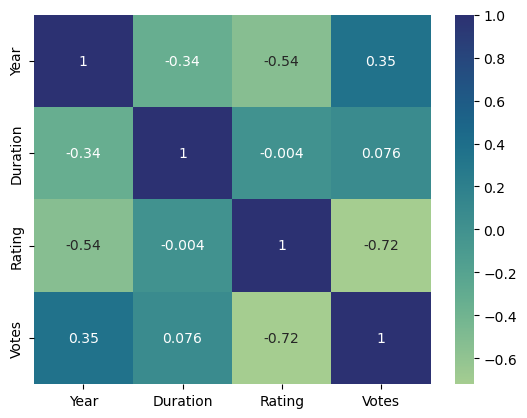

In [39]:
sns.heatmap(df.corr(),cmap='crest',annot=True)

In [40]:
df=df[(df['Year']>year_low) & (df['Year']<year_upper)]
df.shape

(5576, 10)

In [41]:
label=LabelEncoder()
df['Name']=label.fit_transform(df['Name'])
df['Genre']=label.fit_transform(df['Genre'])
df['Director']=label.fit_transform(df['Director'])
df['Actor 1']=label.fit_transform(df['Actor 1'])
df['Actor 2']=label.fit_transform(df['Actor 2'])
df['Actor 3']=label.fit_transform(df['Actor 3'])

In [42]:
linear=LinearRegression()

In [43]:
x=df.drop('Rating',axis=1)
y=df['Rating']

In [44]:
train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=0.3,random_state=42)

In [45]:
linear.fit(train_x,train_y)
pre_test=linear.predict(test_x)

In [46]:
pre_test

array([5.97132138, 5.58631702, 6.93588044, ..., 5.76520145, 5.82787965,
       6.3642199 ])

In [47]:
pre_train=linear.predict(train_x)

In [48]:
score_test=r2_score(test_y,pre_test)
score_train=r2_score(train_y,pre_train)
print("print r2_score",score_test)
print("print r2_score",score_train)


print r2_score 0.640905212913775
print r2_score 0.6245430127184939


In [49]:
RL=Ridge(alpha=10.0)
RL.fit(train_x,train_y)
RL_pre_test=RL.predict(test_x)
RL_pre_train=RL.predict(train_x)
r2_RL_test=r2_score(test_y,RL_pre_test)
r2_RL_train=r2_score(train_y,RL_pre_train)
print("print r2_score",r2_RL_test)
print('print r2_score',r2_RL_train)
mse = mean_squared_error(test_y, RL_pre_test)
print(mse)

print r2_score 0.6409051461337194
print r2_score 0.6245430127096617
0.08376976245717391


In [50]:
param={'alpha':[0.01, 0.1, 1.0, 10.0]}
grid=GridSearchCV(estimator=RL,param_grid=param,cv=5)
grid.fit(train_x,train_y)
print(grid.best_params_,grid.best_estimator_)

{'alpha': 10.0} Ridge(alpha=10.0)


In [51]:
kf=KFold(n_splits=10,random_state=42,shuffle=True)
cv=cross_val_score(RL,x,y,cv=kf,n_jobs=-1)
print('Accuracy : ',cv.mean()*100)

Accuracy :  62.75231692338251


In [52]:
rfk=RepeatedKFold(n_splits=10,random_state=42,n_repeats=5)
cv1=cross_val_score(RL,x,y,cv=rfk,n_jobs=-1)
print('Accuracy : ',cv1.mean()*100)

Accuracy :  62.748686977979595


In [53]:
LGBMR = LGBMRegressor(n_estimators=100, random_state=60)
LGBMR.fit(train_x, train_y)
lgbm_pre_test = LGBMR.predict(test_x)
lgbm_pre_train=LGBMR.predict(train_x)
r2_test_lgbm=r2_score(test_y,lgbm_pre_test)
r2_train_lgbm=r2_score(train_y,lgbm_pre_train)
print("print r2_score",r2_test_lgbm)
print('print r2_score',r2_train_lgbm)
mse_lgbm = mean_squared_error(test_y, RL_pre_test)
print(mse_lgbm)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1770
[LightGBM] [Info] Number of data points in the train set: 3903, number of used features: 9
[LightGBM] [Info] Start training from score 5.886358
print r2_score 0.9997622184065583
print r2_score 0.9999066667870229
0.08376976245717391


In [54]:
cv2=cross_val_score(LGBMR,x,y,cv=kf,n_jobs=-1)
print('Accuracy : ',cv2.mean()*100)

Accuracy :  99.99043249585812


In [55]:
cv3=cross_val_score(LGBMR,x,y,cv=rfk,n_jobs=-1)
print('Accuracy : ',cv3.mean()*100)

Accuracy :  99.98848328169117
